In [1]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
key = jax.random.PRNGKey(0)

In [3]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

In [11]:
dist = 10.1095

R = jnp.array([[dist/2,0,0],[-dist/2,0,0]])     # nuclei positions
k = jnp.array([1.,1.])                          # potential energy coefficients (nuclear charge)

In [12]:
def calc_E_nuc():
    acc = 0
    for i in range(len(R)):
        for j in range(i + 1, len(R)):
            d = jnp.sqrt(jnp.sum((R[i] - R[j])**2))
            acc += k[i] * k[j] / d


    return acc

E_nuc = calc_E_nuc()

In [13]:
#
# The potential energy function depending on the coordinates
#
def potential(x, params):
    x = jnp.expand_dims(x, axis = 1)
    r = jnp.expand_dims(R,  axis = 0)
    d = jnp.sqrt(jnp.sum((x - r)**2, axis = 2))
    return - jnp.sum(k/d ,axis = 1) + E_nuc


# the hamiltonian
hamiltonian = module.hamiltonians.Particles(masses = [1], potential = potential)


In [14]:
class NN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20, name="dense2", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = netket.nn.activation.log_cosh(x)
        x = nn.Dense(20, name="dense3", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = netket.nn.activation.log_cosh(x)
        x = nn.Dense(15, name="dense4", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = netket.nn.activation.log_cosh(x)
        x = nn.Dense(1, name="dense5", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = netket.nn.activation.log_cosh(x)
        return -jnp.squeeze(x)
    
#, bias_init=jax.random.normal

In [15]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (3,))

        self.nn = NN()
        self.lcao = module.wavefunctions.LCAO()
        self.lcao_param = self.lcao.init_parameters(R, k, jnp.array([1.,1.])) 


    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((7,)))

        return nn_param
    
    def eval_nn(self, parameters, x):
        x1 = x[:, 0]
        x2 = x[:, 1]
        x3 = x[:, 2]
        r0 = x[:, 0]**2                                       # molecular axis
        r1 = x[:, 1]**2 + x[:, 2]**2                           # radial distance
        r2 = x[:, 0]**2 + x[:, 1]**2 + x[:, 2]**2             # central distance
        r3 = (x[:, 0] - dist/2)**2 + x[:, 1]**2 + x[:, 2]**2
        r4 = (x[:, 0] + dist/2)**2 + x[:, 1]**2 + x[:, 2]**2

        coord = jnp.stack((x1,x2,x3,r0, r1, r2, r3 + r4), axis = 1)

        return self.nn.apply(parameters, coord)
    
    def calc_logpsi(self, parameters, x):
        return self.lcao.calc_logpsi(self.lcao_param, x) + self.eval_nn(parameters, x)

In [16]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

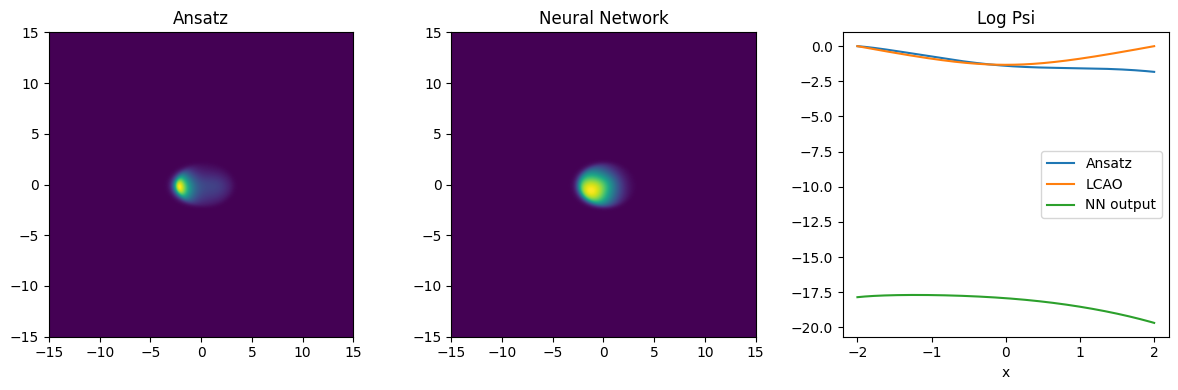

In [18]:
f, axs = plt.subplots(1, 3, figsize = (12,4))

xs = jnp.linspace(-15, 15, num = 1000)
ys = jnp.linspace(-15, 15, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[0].imshow(res, extent = [-15, 15, -15, 15])
axs[0].set_title("Ansatz")

res = ansatz.eval_nn(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[1].imshow(jnp.exp(res), extent = [-15, 15, -15, 15])
axs[1].set_title("Neural Network")


r, line = getLine(0, jnp.pi/2, r_max=2)
psi = ansatz.calc_logpsi(param, line)
psi_lcao = ansatz.lcao.calc_logpsi(ansatz.lcao_param, line)
nn_out = ansatz.eval_nn(param, line)

axs[2].plot(r, psi - jnp.max(psi), label = "Ansatz")
axs[2].plot(r, psi_lcao - jnp.max(psi_lcao), label = "LCAO")
axs[2].plot(r, nn_out, label = "NN output")

axs[2].set_title("Log Psi")
axs[2].legend()
axs[2].set_xlabel("x")

f.tight_layout()

In [14]:
class SymmetrySampler(module.samplers.MCMC):
    def propose(self, key, element):
        subkey, _ = jax.random.split(key)

        mirrorprob = 0.01

        var = jax.random.normal(key, shape = self.shape) * jnp.sqrt(self.variance)
        inv = -element

        decide = jax.random.uniform(key)

        proposal = jnp.where(decide < mirrorprob, inv, element + var)

        return subkey, proposal
sampler = SymmetrySampler(ansatz, 0.5)

In [15]:
subsampling = 20

In [17]:
def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, jax.random.normal(key, shape = (3,)), N*subsampling)
    return samples[0:-1:subsampling], ratio

## 2. Energy Minimisation

In [23]:
# @partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
# def calc_grad_E(hamiltonian, orbital, parameters, samples):
#     """
#     Calculates the gradient of the energy and the energy itself on a batch of samples.
#     """

#     E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
#     E = jnp.mean(E_loc)
#     dE = jnp.std(E_loc)
#     grad_log = orbital.grad_logpsi(parameters, samples)

#     m = lambda tree: 2*jnp.real(jnp.mean(jnp.swapaxes(jnp.swapaxes(tree, 0, -1) * (E_loc - E), 0, -1), axis = 0))

#     return jax.tree_util.tree_map(m, grad_log), E, dE

@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    dE = jnp.std(E_loc)

    logpsi_red = lambda parameters: orbital.calc_logpsi(parameters, samples)
    y, v = jax.vjp(logpsi_red, parameters)
    N = samples.shape[0]

    m = lambda tree: 2*jnp.real(tree/N)

    return jax.tree_util.tree_map(m, v(E_loc - E))[0], E, dE

In [24]:
def eval_S1(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]

    a = jax.jvp(f, (parameters,), (v,))[1]
    b = jax.vjp(f, parameters)[1](a)[0]
    return jax.tree_util.tree_map(lambda x: 1/N*x, b)

def eval_S2(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]
    e = jnp.ones(N)

    a = jnp.sum(jax.jvp(f, (parameters,), (v,))[1])
    b = jax.vjp(f, parameters)[1](e)[0]
    return  jax.tree_util.tree_map(lambda v: 1/N**2 * a * v, b)

@partial(jax.jit, static_argnames=['orbital'])
def eval_S(orbital, parameters, samples, v):
    s1 = eval_S1(orbital, parameters, samples, v)
    s2 = eval_S2(orbital, parameters, samples, v)
    return jax.tree_util.tree_map(lambda a,b: a-b, s1, s2)

In [69]:
eps = 1e-4

def reg_S(ansatz, param, samples, v):
    u = eval_S(ansatz, param, samples, v)
    return jax.tree_util.tree_map(lambda a,b: a + eps * b, u, v)

@jax.jit
def calc_natural_grad(param, samples):
    A = lambda v: reg_S(ansatz, param, samples, v)
    b, E, dE = calc_grad_E(hamiltonian, ansatz, param, samples)
    return jax.scipy.sparse.linalg.cg(A, b)[0], E, dE

In [70]:
stats = {"E":[], "dE":[], "ratio":[], "N_samples": []}
param = ansatz.init_param(key)

In [143]:
N = 4000
epoch = 200

# define
optimizer = optax.sgd(learning_rate=0.03)

# initialise
optimizer_state = optimizer.init(param)

for i in tqdm(range(epoch)):
    key, _ = jax.random.split(key)
    samples, ratio = get_samples(N)
    grad, E, dE = calc_natural_grad(param, samples)

    stats["E"].append(E)
    stats["dE"].append(dE)
    stats["ratio"].append(ratio)
    stats["N_samples"].append(N)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, param)

    param = optax.apply_updates(param, updates)

100%|██████████| 200/200 [02:35<00:00,  1.28it/s]


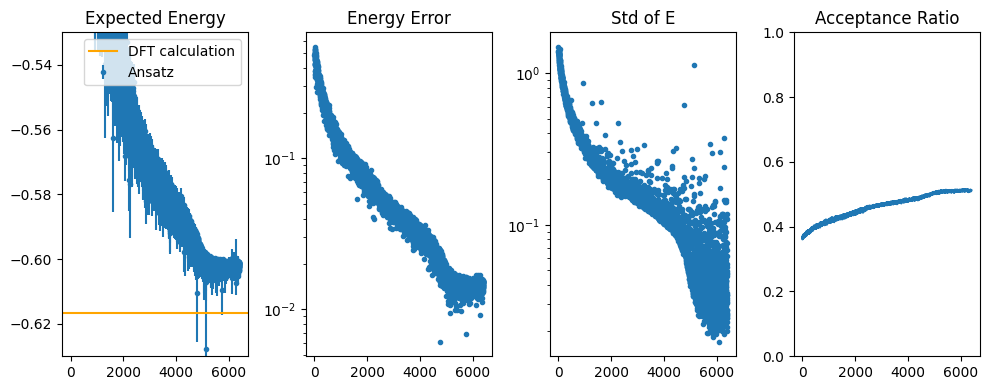

In [154]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

f, ax = plt.subplots(1, 4, figsize = (10, 4))
i = np.arange(len(stats["E"]))

ax[0].errorbar(i, numpy_stats["E"], yerr = numpy_stats["dE"]/jnp.sqrt(numpy_stats["N_samples"]), fmt = ".", label = "Ansatz")
# ax[0].fill_between(i, numpy_stats["E"] - numpy_stats["dE"], numpy_stats["E"] + numpy_stats["dE"], alpha = 0.5)
ax[0].set_title("Expected Energy")
ax[0].axhline(-0.616515, label = "DFT calculation", color = "orange")
ax[0].legend(loc = "upper right")
ax[0].set_ylim(-0.63, -0.53)

ax[1].scatter(i, jnp.abs(numpy_stats["E"]+0.616515) , label = "error", marker = ".")
ax[1].set_title("Energy Error")
ax[1].set_yscale("log")

ax[2].scatter(i, stats["dE"], marker = ".")
ax[2].set_title("Std of E")
ax[2].set_yscale("log")

ax[3].plot(stats["ratio"])
ax[3].set_ylim(0,1)
ax[3].set_title("Acceptance Ratio")

f.tight_layout()

n_param = sum(x.size for x in jax.tree_util.tree_leaves(param))
# plt.savefig("../../plots/natgrad"+str(n_param)+"param.pdf")


In [153]:
with open("tmp/check.obj", "rb") as f:
    param = pickle.load(f)

In [146]:
with open("tmp/check.obj", "wb") as f:
    pickle.dump(param, f)

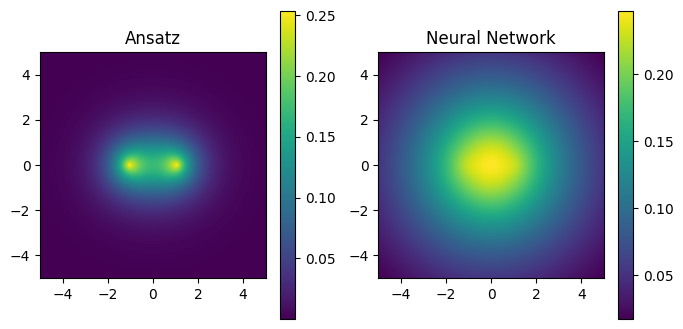

In [147]:
f, axs = plt.subplots(1, 2, figsize = (8,4))

xs = jnp.linspace(-5, 5, num = 1000)
ys = jnp.linspace(-5, 5, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
im1 = axs[0].imshow(res, extent = [-5, 5, -5, 5])
axs[0].set_title("Ansatz")
plt.colorbar(im1, ax = axs[0])

res = ansatz.eval_nn(param, im.reshape(-1, 3)).reshape(xss.shape)
im2 = axs[1].imshow(jnp.exp(res), extent = [-5, 5, -5, 5])
axs[1].set_title("Neural Network")
plt.colorbar(im2, ax = axs[1])


Text(0.5, 0, 'x')

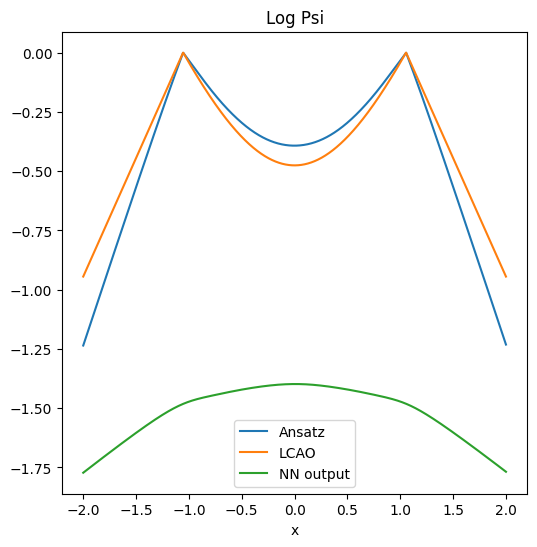

In [148]:
plt.figure(figsize=(6, 6))

r, line = getLine(0, jnp.pi/2, r_max=2)
psi = ansatz.calc_logpsi(param, line)
psi_lcao = ansatz.lcao.calc_logpsi(ansatz.lcao_param, line)
nn_out = ansatz.eval_nn(param, line)

plt.plot(r, psi - jnp.max(psi), label = "Ansatz")
plt.plot(r, psi_lcao - jnp.max(psi_lcao), label = "LCAO")
plt.plot(r, nn_out, label = "NN output")


plt.title("Log Psi")
plt.legend()
plt.xlabel("x")

In [150]:
N = 10000
key, _ = jax.random.split(key)
samples, ratio = get_samples(N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc),"+/-", jnp.std(H_loc)/jnp.sqrt(N))
print("Energy Error:", (jnp.mean(H_loc) + 0.616515)/0.616515)
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.5123650000000001
Expected Energy: -0.601136894337856 +/- 0.0002840741250327003
Energy Error: 0.02494360341945295
Std of Expected Energy: 0.02840741250327003


In [152]:
27.2114 * 0.0249436 * 0.616515
# eV

0.4184597270493156